# PyTorch Basics - Samplers

By [Akshaj Verma](https://akshajverma.com)

This notebook takes you through an implementation of `random_split`, `SubsetRandomSampler`, and `WeightedRandomSampler` on [Natural Images](https://www.kaggle.com/prasunroy/natural-images) data using PyTorch.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

In [2]:
np.random.seed(0)
torch.manual_seed(0)

In [3]:
%matplotlib inline
sns.set_style('darkgrid')

## Define Data Path

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)

root_dir = "../../data/computer_vision/image_classification/natural-images/"
print("The data lies here =>", root_dir)

We're using => cpu
The data lies here => ../../data/computer_vision/image_classification/natural-images/


## Define Transforms

In [5]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

## Initialize Dataset

In [6]:
natural_img_dataset = datasets.ImageFolder(root = root_dir,
                                      transform = image_transforms["train"]
                                     )

natural_img_dataset

Dataset ImageFolder
    Number of datapoints: 6899
    Root location: ../../data/computer_vision/image_classification/natural-images/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

## Class <=> ID Mapping

In [7]:
natural_img_dataset.class_to_idx

{'airplane': 0,
 'car': 1,
 'cat': 2,
 'dog': 3,
 'flower': 4,
 'fruit': 5,
 'motorbike': 6,
 'person': 7}

In [8]:
idx2class = {v: k for k, v in natural_img_dataset.class_to_idx.items()}
idx2class

{0: 'airplane',
 1: 'car',
 2: 'cat',
 3: 'dog',
 4: 'flower',
 5: 'fruit',
 6: 'motorbike',
 7: 'person'}

## Observe Class Distribution

In [9]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict

In [10]:
print("Distribution of classes: \n", get_class_distribution(natural_img_dataset))

Distribution of classes: 
 {'airplane': 727, 'car': 968, 'cat': 885, 'dog': 702, 'flower': 843, 'fruit': 1000, 'motorbike': 788, 'person': 986}


Text(0.5, 1.0, 'Natural Images Class Distribution')

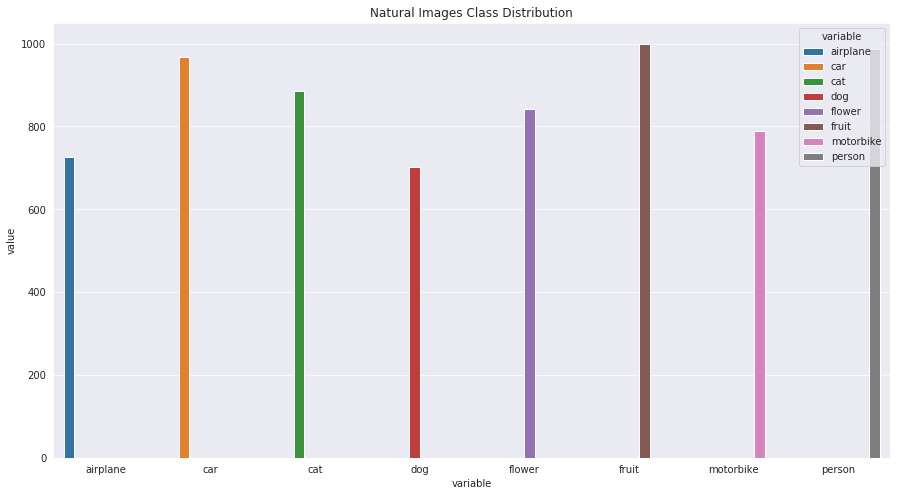

In [11]:
plt.figure(figsize=(15,8))
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(natural_img_dataset)]).melt(), x = "variable", y="value", hue="variable").set_title('Natural Images Class Distribution')

## `random_split()`

`random_split(dataset, lengths)` works directly on the dataset. The function expects 2 input arguments. The first argument is the dataset. The second is a tuple of lengths. If we want to split our dataset into 2 parts, we will provide a tuple with 2 numbers. These numbers are the sizes of the corresponding datasets after the split. 

Our dataset has 6899 images. If we want to split this into 2 parts (*train/test, train/val*) of size (6000, 899), we will call random split as `random_split(6000, 899)`.

Let's split our dataset into train and val sets.

In [12]:
train_dataset, val_dataset = random_split(natural_img_dataset, (6000, 899))

Pass data to the dataloader.

In [13]:
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=1)
val_loader = DataLoader(dataset=val_dataset, shuffle=False, batch_size=1)

In [14]:
print("Length of the train_loader:", len(train_loader))
print("Length of the val_loader:", len(val_loader))

Length of the train_loader: 6000
Length of the val_loader: 899


Note that we have used a `batch_size = 1`. If we increase the `batch_size`, the number of images would be the same but the length of train/val loaders would change.

Let's take a look at the distribution of classes in the train and val loaders.

In [15]:
def get_class_distribution_loaders(dataloader_obj, dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for _,j in dataloader_obj:
        y_idx = j.item()
        y_lbl = idx2class[y_idx]
        count_dict[str(y_lbl)] += 1
            
    return count_dict

Text(0.5, 1.0, 'Val Set')

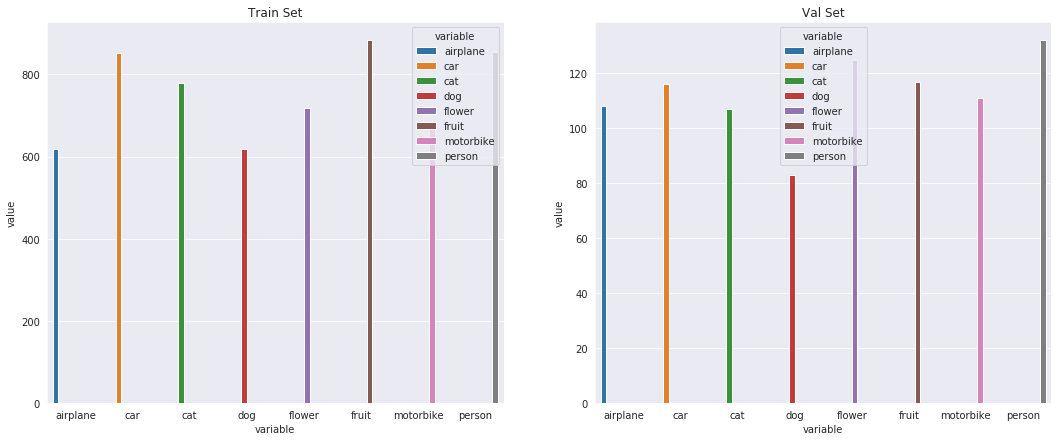

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,7))

sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution_loaders(train_loader, natural_img_dataset)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Train Set')
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution_loaders(val_loader, natural_img_dataset)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Val Set')

## `SubsetRandomSampler()`

`SubsetRandomSampler(indices)` takes as input the indices of data. 

We first create our samplers and then we'll pass it to our dataloaders. 

1. Create a list of indices. 
2. Shuffle the indices. 
3. Split the indices based on train-val percentage.
4. Create `SubsetRandomSampler`.

Create a list of indices from 0 to length of dataset.

In [17]:
dataset_size = len(natural_img_dataset)
dataset_indices = list(range(dataset_size))

Shuffle the list of indices using `np.shuffle`.

In [18]:
np.random.shuffle(dataset_indices)

Create the split index. We choose the split index to be 20% (0.2) of the dataset size.

In [19]:
val_split_index = int(np.floor(0.2 * dataset_size))

Slice the lists to obtain 2 lists of indices, one for train and other for test.

> `0`-----------`val_split_index`------------------------------`n`.

Train => `val_split_index` to `n`


Val => `0` to `val_split_index`

In [20]:
train_idx, val_idx = dataset_indices[val_split_index:], dataset_indices[:val_split_index]

Finally, create samplers.

In [21]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

Now, we will pass the samplers to our dataloader. Note that `shuffle=True` cannot be used when you're using the `SubsetRandomSampler`.

In [22]:
train_loader = DataLoader(dataset=natural_img_dataset, shuffle=False, batch_size=1, sampler=train_sampler)
val_loader = DataLoader(dataset=natural_img_dataset, shuffle=False, batch_size=1, sampler=val_sampler)

Now, we'll plot the class distribution in our dataloaders.

Text(0.5, 1.0, 'Val Set')

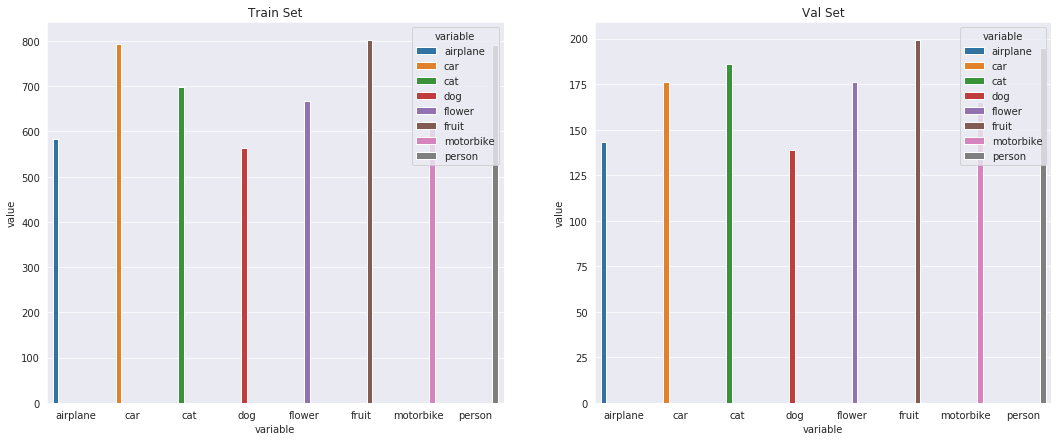

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,7))

sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution_loaders(train_loader, natural_img_dataset)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Train Set')
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution_loaders(val_loader, natural_img_dataset)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Val Set')

As we can observe, the number of samples per class in the validation set is proportional to the number in train set.

## `WeightedRandomSampler()`

`WeightedRandomSampler` is used, unlike `random_split` and `SubsetRandomSampler`, to ensure that each batch sees a proportional number of all classes.


1. Get all the target classes. 
2. Shuffle the target classes.
3. Get the class weights. Class weights are the reciprocal of the number of items per class.
4. Obtain corresponding weight for each target sample.

Obtain the list of target classes and shuffle.

In [24]:
target_list = torch.tensor(natural_img_dataset.targets)
target_list = target_list[torch.randperm(len(target_list))]

Get the class counts and calculate the weights/class by taking its reciprocal.

In [25]:
class_count = [i for i in get_class_distribution(natural_img_dataset).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
class_weights

tensor([0.0014, 0.0010, 0.0011, 0.0014, 0.0012, 0.0010, 0.0013, 0.0010])

Assign the weight of each class to all the samples. 

In [26]:
class_weights_all = class_weights[target_list]
class_weights_all

tensor([0.0010, 0.0012, 0.0014,  ..., 0.0010, 0.0014, 0.0010])

Pass the `weight` and `number of samples` to the WeightedRandomSampler.

In [27]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

Pass the sampler to the dataloader.

In [28]:
train_loader = DataLoader(dataset=natural_img_dataset, shuffle=False, batch_size=8, sampler=weighted_sampler)

In [29]:
len(train_loader)

863

In [30]:
batch_count_dict = {k:[] for k,v in natural_img_dataset.class_to_idx.items()}
batch_count_dict

{'airplane': [],
 'car': [],
 'cat': [],
 'dog': [],
 'flower': [],
 'fruit': [],
 'motorbike': [],
 'person': []}

In [31]:
for _, batch in train_loader:
    temp_batch_count_dict = {k:0 for k,v in natural_img_dataset.class_to_idx.items()}
    
    for item in batch:
        op_id = item.item()
        op_class = idx2class[op_id]
        temp_batch_count_dict[op_class] += 1
        
    {batch_count_dict[k].append(v) for k,v in temp_batch_count_dict.items()}

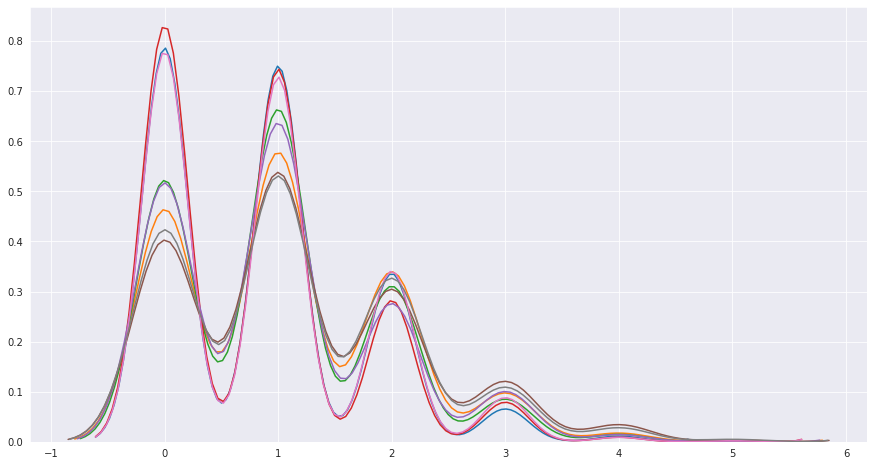

In [32]:
plt.figure(figsize=(15,8))


for c in batch_count_dict.keys():
    sns.distplot(batch_count_dict[c], hist=False)